In [11]:
from transformers import AutoTokenizer
from transformers import RobertaForSequenceClassification
from scipy.special import softmax

MODEL= f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = RobertaForSequenceClassification.from_pretrained(MODEL, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

df = pd.read_csv('./input/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [21]:
from tqdm.notebook import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        res[myid] = polarity_scores_roberta(text)
    except IndexError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [22]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [25]:
print(results_df.head)

<bound method NDFrame.head of       Id  roberta_neg  roberta_neu  roberta_pos   ProductId          UserId  \
0      1     0.009624     0.049980     0.940395  B001E4KFG0  A3SGXH7AUHU8GW   
1      2     0.508986     0.452414     0.038600  B00813GRG4  A1D87F6ZCVE5NK   
2      3     0.003229     0.098067     0.898704  B000LQOCH0   ABXLMWJIXXAIN   
3      4     0.002295     0.090219     0.907486  B000UA0QIQ  A395BORC6FGVXV   
4      5     0.001635     0.010302     0.988063  B006K2ZZ7K  A1UQRSCLF8GW1T   
..   ...          ...          ...          ...         ...             ...   
493  496     0.001906     0.009862     0.988232  B000G6RYNE   APGAA43E3WPN7   
494  497     0.004415     0.034215     0.961369  B000G6RYNE    ABR7HU5H1KNE   
495  498     0.006427     0.074537     0.919036  B000G6RYNE   AJQD2WWJYOYFQ   
496  499     0.865614     0.119366     0.015020  B000G6RYNE  A16YH487W9ZYO0   
497  500     0.002440     0.011327     0.986233  B000G6RYNE   A83YQC1XOU4CS   

                     

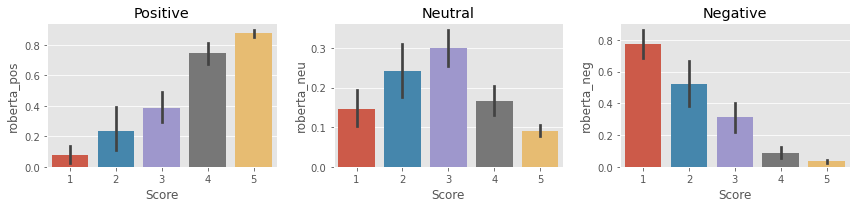

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


In [2]:
# Run Roberta Model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [3]:
print(polarity_scores_roberta('They dried out really quickly. Pretty bad quality when half the box dried out within a month of getting them.'))

{'roberta_neg': 0.9550338, 'roberta_neu': 0.04017315, 'roberta_pos': 0.0047932044}


In [4]:
print(polarity_scores_roberta('These Arteza Markers works perfect with the custom dry erase signs I purchased at Awe Snap Crafts. I purchase these markers along with custom handwriting sign for my daycare and the children loves them.  The markers are very vibrant and easy to work with.'))

{'roberta_neg': 0.0009269896, 'roberta_neu': 0.011523713, 'roberta_pos': 0.9875493}


In [5]:
print(polarity_scores_roberta('I love using these in my classroom. They work well for my students and my first set lasted almost the entire year. Its easy to see when they need to be thrown away. On some surfaces they can be hard to erase if left on for a while. I try not to use them if Im writing an anchor chart on my whiteboard.'))

{'roberta_neg': 0.03329607, 'roberta_neu': 0.10278754, 'roberta_pos': 0.8639165}
